# LSTM approach

In [1]:
import pandas as pd 
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.manual_seed(42)
np.random.seed(424)

In [3]:
train_data = pd.read_csv(r"C:\Users\pragy\cloud_architecture\neural_symbolic\data\train_data.csv")
test_data = pd.read_csv(r"C:\Users\pragy\cloud_architecture\neural_symbolic\data\test_data.csv")

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110474 entries, 0 to 110473
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   log_id                         110474 non-null  int64  
 1   student_id                     110474 non-null  int64  
 2   assignment_id                  110474 non-null  int64  
 3   problem_id                     110474 non-null  int64  
 4   start_time                     110474 non-null  object 
 5   time_on_task                   107533 non-null  float64
 6   answer_before_tutoring         108117 non-null  object 
 7   fraction_of_hints_used         51624 non-null   float64
 8   attempt_count                  110474 non-null  int64  
 9   answer_given                   110474 non-null  bool   
 10  problem_completed              110474 non-null  bool   
 11  correct                        82565 non-null   object 
 12  next_correct                  

In [5]:
numerical_features = []
categorical_features = []

for col in train_data.columns:
    if train_data[col].dtype in ['float64','int64','float32','int32']:
        numerical_features.append(col)
    else:
        categorical_features.append(col)

print(f"Numerical columns: {numerical_features}")
print(f"Categorical columns: {categorical_features}")
        

Numerical columns: ['log_id', 'student_id', 'assignment_id', 'problem_id', 'time_on_task', 'fraction_of_hints_used', 'attempt_count', 'student_answer_count', 'mean_correct', 'mean_time_on_task', 'class_id', 'started_problem_sets_count', 'completed_problem_sets_count', 'started_skill_builders_count', 'mastered_skill_builders_count', 'answered_problems_count', 'mean_problem_correctness', 'mean_problem_time_on_task', 'mean_class_score']
Categorical columns: ['start_time', 'answer_before_tutoring', 'answer_given', 'problem_completed', 'correct', 'next_correct', 'content_source', 'skills', 'problem_type', 'tutoring_types', 'account_creation_date']


In [6]:
exclude_numerical = ['log_id', 'assignment_id', 'problem_id', 'class_id']
exclude_categorical = ['next_correct', 'start_time', 'account_creation_date']

clean_numerical_features = [col for col in numerical_features if col not in exclude_numerical]
clean_categorical_features = [col for col in categorical_features if col not in exclude_categorical]

In [7]:
train_data[clean_numerical_features] = train_data[clean_numerical_features].fillna(0)
test_data[clean_numerical_features] = test_data[clean_numerical_features].fillna(0)

In [8]:
label_encoders = {}

for col in clean_categorical_features:
    train_data[col] = train_data[col].fillna('Missing').astype(str)
    test_data[col] = test_data[col].fillna('Missing').astype(str)

    le = LabelEncoder()
    all_values = pd.concat([train_data[col], test_data[col]]).unique()
    le.fit(all_values)

    train_data[f'{col}_encoded'] = le.transform(train_data[col])
    test_data[f'{col}_encoded'] = le.transform(test_data[col])

    label_encoders[col] = le
    print(f"Encoded {len(le.classes_)} unique values")

encoded_categorical_features = [f'{col}_encoded' for col in clean_categorical_features]

Encoded 3 unique values
Encoded 2 unique values
Encoded 2 unique values
Encoded 3 unique values
Encoded 14 unique values
Encoded 666 unique values
Encoded 11 unique values
Encoded 8 unique values


In [9]:
features_to_scale = [col for col in clean_numerical_features if col != 'student_id']

scaler = StandardScaler()
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])
test_data[features_to_scale] = scaler.transform(test_data[features_to_scale])

In [10]:
lstm_numerical_features = features_to_scale
lstm_categorical_features = encoded_categorical_features

In [11]:
SEQ_LEN = 12
BATCH_SIZE = 64

class StudentSequenceDataset(Dataset):
    def __init__(self, df, numerical_features, categorical_features, seq_len=SEQ_LEN):
        self.seq_len = seq_len
        self.samples = []
        
        print(f"Creating sequences for {df['student_id'].nunique()} students...")
        
        for student_id, group in df.groupby('student_id'):
            group = group.sort_values('start_time').reset_index(drop=True)
            n = len(group)
            
            if n < seq_len + 1:
                continue
                
            x_numerical = group[numerical_features].values.astype('float32')
            x_categorical = group[categorical_features].values.astype('int64') 
            targets = group['next_correct'].values.astype('float32')
            
            for i in range(n - seq_len):
                self.samples.append({
                    'numerical': x_numerical[i:i+seq_len].astype(np.float32),     
                    'categorical': x_categorical[i:i+seq_len].astype(np.int64),  
                    'target': targets[i+seq_len-1]              
                })
        
        print(f"Created {len(self.samples)} sequences")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        return (
            torch.tensor(sample['numerical'], dtype=torch.float32),
            torch.tensor(sample['categorical'], dtype=torch.int64),
            torch.tensor(sample['target'], dtype=torch.float32)
        )

In [12]:
train_dataset = StudentSequenceDataset(
    train_data, 
    lstm_numerical_features, 
    lstm_categorical_features, 
    seq_len=SEQ_LEN
)

test_dataset = StudentSequenceDataset(
    test_data, 
    lstm_numerical_features, 
    lstm_categorical_features, 
    seq_len=SEQ_LEN
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Creating sequences for 10000 students...
Created 15678 sequences
Creating sequences for 1000 students...
Created 1459 sequences


In [13]:
sample_batch = next(iter(train_loader))
x_num, x_cat, y = sample_batch

x_num.shape, x_cat.shape, y.shape


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\pragy\anaconda3\envs\main\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\pragy\anaconda3\envs\main\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "c:\Users\pragy\anaconda3\envs\main\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\

(torch.Size([64, 12, 14]), torch.Size([64, 12, 8]), torch.Size([64]))

In [14]:
vocab_sizes = {}
for i, col in enumerate(lstm_categorical_features):
    original_col = col.replace('_encoded', '')
    vocab_size = len(label_encoders[original_col].classes_)
    vocab_sizes[col] = vocab_size
    print(f"{col}: {vocab_size} unique values")

answer_before_tutoring_encoded: 3 unique values
answer_given_encoded: 2 unique values
problem_completed_encoded: 2 unique values
correct_encoded: 3 unique values
content_source_encoded: 14 unique values
skills_encoded: 666 unique values
problem_type_encoded: 11 unique values
tutoring_types_encoded: 8 unique values


In [15]:
class NextCorrectLSTM(nn.Module):
    def __init__(self, num_numerical_features, categorical_vocab_sizes, embed_dim=16, hidden_dim=128, num_layers=2, dropout=0.2):
        super(NextCorrectLSTM, self).__init__()
        
        self.num_numerical_features = num_numerical_features
        self.categorical_vocab_sizes = categorical_vocab_sizes
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        
        self.embeddings = nn.ModuleList([
            nn.Embedding(vocab_size, embed_dim) 
            for vocab_size in categorical_vocab_sizes.values()
        ])
        
        total_embed_dim = len(categorical_vocab_sizes) * embed_dim
        lstm_input_dim = num_numerical_features + total_embed_dim
        
        self.lstm = nn.LSTM(
            input_size=lstm_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(), 
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    
        self._init_weights()
    
    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.uniform_(param, -0.1, 0.1)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def forward(self, numerical_features, categorical_features):
        batch_size, seq_len = numerical_features.shape[:2]
        
        embedded_cats = []
        for i, embedding in enumerate(self.embeddings):
            cat_feature = categorical_features[:, :, i] 
            embedded = embedding(cat_feature) 
            embedded_cats.append(embedded)
        
        if embedded_cats:
            categorical_embedded = torch.cat(embedded_cats, dim=-1)  
            combined_features = torch.cat([numerical_features, categorical_embedded], dim=-1)
        else:
            combined_features = numerical_features
        
        lstm_out, (hidden, _) = self.lstm(combined_features)
        final_hidden = hidden[-1]  

        prediction = self.classifier(final_hidden)
        
        return prediction.squeeze()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_numerical = len(lstm_numerical_features)
embed_dim = 16
hidden_dim = 64
num_layers = 1
dropout = 0.4

model = NextCorrectLSTM(
    num_numerical_features=num_numerical,
    categorical_vocab_sizes=vocab_sizes,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"-Total: {total_params:,}")
print(f"-Trainable: {trainable_params:,}")

Using device: cuda

Model parameters:
-Total: 70,865
-Trainable: 70,865


In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.001, weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    patience=3, 
    factor=0.3
)

In [18]:
model.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    x_num, x_cat, y = sample_batch
    
    x_num = x_num.to(device)
    x_cat = x_cat.to(device)
    y = y.to(device)
    
    predictions = model(x_num, x_cat)
    loss = criterion(predictions, y)
    
    print(f"\nForward pass successful!\n========================")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Sample predictions: {predictions[:5]}")
    print(f"Sample targets: {y[:5]}")
    print(f"Loss: {loss.item():.4f}")


Forward pass successful!
Predictions shape: torch.Size([64])
Sample predictions: tensor([0.4750, 0.4598, 0.4759, 0.5053, 0.4893], device='cuda:0')
Sample targets: tensor([1., 0., 0., 1., 1.], device='cuda:0')
Loss: 0.6912


In [19]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_idx, (x_num, x_cat, y) in enumerate(train_loader):
        x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
        
        optimizer.zero_grad()
        predictions = model(x_num, x_cat)
        loss = criterion(predictions, y)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for x_num, x_cat, y in val_loader:
            x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
            
            predictions = model(x_num, x_cat)
            loss = criterion(predictions, y)
            
            total_loss += loss.item()
            
            all_predictions.extend(predictions.detach().cpu().tolist())
            all_targets.extend(y.detach().cpu().tolist())
    
    avg_loss = total_loss / len(val_loader)
    predictions_binary = [1 if p > 0.5 else 0 for p in all_predictions]
    
    accuracy = accuracy_score(all_targets, predictions_binary)
    precision = precision_score(all_targets, predictions_binary, zero_division=0)
    recall = recall_score(all_targets, predictions_binary, zero_division=0)
    f1 = f1_score(all_targets, predictions_binary, zero_division=0)
    
    try:
        auc = roc_auc_score(all_targets, all_predictions)
    except ValueError:
        auc = 0.0
    return avg_loss, accuracy, precision, recall, f1, auc, all_predictions, all_targets


In [20]:
epochs = 20
patience = 5

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
val_aucs = []

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("STARTING TRAINING")

start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 50)

    print("Training...")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    print("Validating...")
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = validate_epoch(
        model, test_loader, criterion, device
    )
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1s.append(val_f1)
    val_aucs.append(val_auc)
    
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    epoch_time = time.time() - epoch_start
    print(f"\nResults:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f}")
    print(f"Val Prec: {val_prec:.4f}")
    print(f"Val Rec: {val_rec:.4f}")
    print(f"Val F1: {val_f1:.4f}")
    print(f"Val AUC: {val_auc:.4f}")
    print(f"LR: {current_lr:.6f}")
    print(f"Time: {epoch_time:.2f}s")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"New best validation loss")
    else:
        patience_counter += 1
        print(f"  ⏳ No improvement ({patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered")
            break

total_time = time.time() - start_time


print("TRAINING COMPLETED")
print(f"Total training time: {total_time:.2f}s")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"Final validation AUC: {val_aucs[-1]:.4f}")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights")


STARTING TRAINING

Epoch 1/20
--------------------------------------------------
Training...
Batch 0/245, Loss: 0.6902
Batch 100/245, Loss: 0.5592
Batch 200/245, Loss: 0.4826
Validating...

Results:
Train Loss: 0.5844
Val Loss: 0.5173
Val Acc: 0.7313
Val Prec: 0.7384
Val Rec: 0.8563
Val F1: 0.7930
Val AUC: 0.8097
LR: 0.001000
Time: 4.02s
New best validation loss

Epoch 2/20
--------------------------------------------------
Training...
Batch 0/245, Loss: 0.5087
Batch 100/245, Loss: 0.5530
Batch 200/245, Loss: 0.5722
Validating...

Results:
Train Loss: 0.5463
Val Loss: 0.5087
Val Acc: 0.7361
Val Prec: 0.7445
Val Rec: 0.8540
Val F1: 0.7955
Val AUC: 0.8161
LR: 0.001000
Time: 3.74s
New best validation loss

Epoch 3/20
--------------------------------------------------
Training...
Batch 0/245, Loss: 0.5261
Batch 100/245, Loss: 0.4819
Batch 200/245, Loss: 0.5789
Validating...

Results:
Train Loss: 0.5291
Val Loss: 0.5081
Val Acc: 0.7416
Val Prec: 0.7495
Val Rec: 0.8563
Val F1: 0.7994
Val AUC

In [21]:

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'vocab_sizes': vocab_sizes,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'model_config': {
        'num_numerical_features': num_numerical,
        'categorical_vocab_sizes': vocab_sizes,
        'embed_dim': embed_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    },
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs,
        'best_val_loss': best_val_loss
    }
}, 'lstm_next_correct_model.pth')

In [22]:
print("="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

model.eval()

print("Getting final predictions on test set...")
final_val_loss, final_accuracy, final_precision, final_recall, final_f1, final_auc, final_predictions, final_targets = validate_epoch(
    model, test_loader, criterion, device
)

print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test Loss:      {final_val_loss:.4f}")
print(f"Test Accuracy:  {final_accuracy:.4f}")
print(f"Test Precision: {final_precision:.4f}")
print(f"Test Recall:    {final_recall:.4f}")
print(f"Test F1-Score:  {final_f1:.4f}")
print(f"Test AUC-ROC:   {final_auc:.4f}")

FINAL MODEL EVALUATION
Getting final predictions on test set...

=== FINAL TEST RESULTS ===
Test Loss:      0.4953
Test Accuracy:  0.7450
Test Precision: 0.7522
Test Recall:    0.8586
Test F1-Score:  0.8019
Test AUC-ROC:   0.8259


In [23]:
final_predictions_binary = [1 if p > 0.5 else 0 for p in final_predictions]

print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(final_targets, final_predictions_binary, target_names=['Incorrect', 'Correct'], digits=4))


=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

   Incorrect     0.7293    0.5739    0.6423       582
     Correct     0.7522    0.8586    0.8019       877

    accuracy                         0.7450      1459
   macro avg     0.7408    0.7162    0.7221      1459
weighted avg     0.7431    0.7450    0.7382      1459



In [24]:
cm = confusion_matrix(final_targets, final_predictions_binary)
print(f"\n=== CONFUSION MATRIX ===")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")


=== CONFUSION MATRIX ===
True Negatives (TN):  334
False Positives (FP): 248
False Negatives (FN): 124
True Positives (TP):  753

Specificity (True Negative Rate): 0.5739
Sensitivity (True Positive Rate): 0.8586


In [25]:
epochs_range = list(range(1, len(train_losses) + 1))

# Training curves data
training_curves_data = {
    'epoch': epochs_range + epochs_range,  # Duplicate for train and val
    'loss': train_losses + val_losses,
    'type': ['Train'] * len(train_losses) + ['Validation'] * len(val_losses)
}

# Metrics over time data
metrics_data = {
    'epoch': epochs_range,
    'accuracy': val_accuracies,
    'precision': val_precisions,
    'recall': val_recalls,
    'f1': val_f1s,
    'auc': val_aucs
}

cm_data = {
    'Predicted_Incorrect': [cm[0,0], cm[1,0]], 
    'Predicted_Correct': [cm[0,1], cm[1,1]],
    'Actual': ['Actual_Incorrect', 'Actual_Correct']
}

print(f"\n=== DATA PREPARED FOR VISUALIZATION ===")
print(f"Training epochs: {len(epochs_range)}")
print(f"Training curves data points: {len(training_curves_data['epoch'])}")
print(f"Metrics data points: {len(metrics_data['epoch'])}")


=== DATA PREPARED FOR VISUALIZATION ===
Training epochs: 17
Training curves data points: 34
Metrics data points: 17


In [26]:
print(f"\n=== SAMPLE PREDICTIONS ANALYSIS ===")

# Show some example predictions
sample_size = 20
print(f"First {sample_size} predictions vs actual:")
print("Pred | Actual | Prob")
print("-" * 20)
for i in range(min(sample_size, len(final_predictions))):
    pred_prob = final_predictions[i]
    pred_class = 1 if pred_prob > 0.5 else 0
    actual = int(final_targets[i])
    print(f"{pred_class:4d} | {actual:6d} | {pred_prob:.3f}")


=== SAMPLE PREDICTIONS ANALYSIS ===
First 20 predictions vs actual:
Pred | Actual | Prob
--------------------
   1 |      0 | 0.764
   1 |      0 | 0.704
   1 |      1 | 0.670
   1 |      1 | 0.654
   1 |      1 | 0.581
   0 |      1 | 0.387
   1 |      1 | 0.917
   1 |      1 | 0.891
   1 |      1 | 0.731
   1 |      0 | 0.720
   1 |      1 | 0.815
   1 |      1 | 0.841
   1 |      1 | 0.808
   1 |      0 | 0.695
   1 |      1 | 0.676
   1 |      1 | 0.597
   0 |      0 | 0.032
   0 |      0 | 0.097
   0 |      0 | 0.113
   0 |      0 | 0.164


In [27]:
performance_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Specificity', 'Sensitivity'],
    'Score': [final_accuracy, final_precision, final_recall, final_f1, final_auc, specificity, sensitivity]
}

print(f"\n=== PERFORMANCE SUMMARY ===")
for metric, score in zip(performance_summary['Metric'], performance_summary['Score']):
    print(f"{metric:12s}: {score:.4f}")


=== PERFORMANCE SUMMARY ===
Accuracy    : 0.7450
Precision   : 0.7522
Recall      : 0.8586
F1-Score    : 0.8019
AUC-ROC     : 0.8259
Specificity : 0.5739
Sensitivity : 0.8586


In [28]:
def predict_next_correct(model, new_data, scaler, label_encoders, device):
    """
    Inference function for new student data
    """
    model.eval()
    
    with torch.no_grad():
        processed_data = new_data.copy()
        numerical_cols = [col for col in lstm_numerical_features if col in processed_data.columns]
        processed_data[numerical_cols] = scaler.transform(processed_data[numerical_cols])
        for col in lstm_categorical_features:
            original_col = col.replace('_encoded', '')
            if original_col in processed_data.columns:
                le = label_encoders[original_col]
                processed_data[col] = processed_data[original_col].map(
                    lambda x: le.transform([x])[0] if x in le.classes_ else 0
                )
        x_num = torch.tensor(processed_data[lstm_numerical_features].values[-SEQ_LEN:]).unsqueeze(0).float().to(device)
        x_cat = torch.tensor(processed_data[lstm_categorical_features].values[-SEQ_LEN:]).unsqueeze(0).long().to(device)
        
        prediction = model(x_num, x_cat)
        
        return prediction.cpu().item()

In [29]:
evaluation_results = {
    'final_metrics': {
        'accuracy': final_accuracy,
        'precision': final_precision,
        'recall': final_recall,
        'f1': final_f1,
        'auc': final_auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    },
    'confusion_matrix': cm.tolist(),
    'training_curves_data': training_curves_data,
    'metrics_data': metrics_data,
    'cm_data': cm_data
}

torch.save(evaluation_results, 'lstm_evaluation_results.pth')

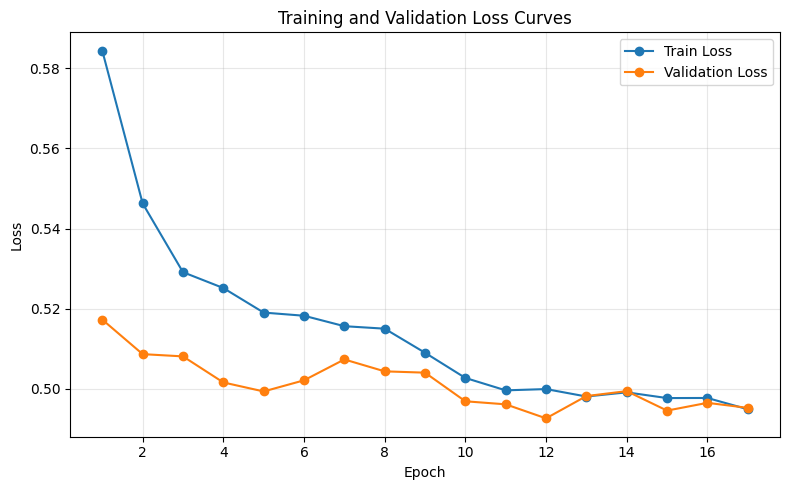

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(training_curves_data['epoch'][:len(train_losses)], training_curves_data['loss'][:len(train_losses)], label='Train Loss', marker='o')
plt.plot(training_curves_data['epoch'][len(train_losses):], training_curves_data['loss'][len(train_losses):], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


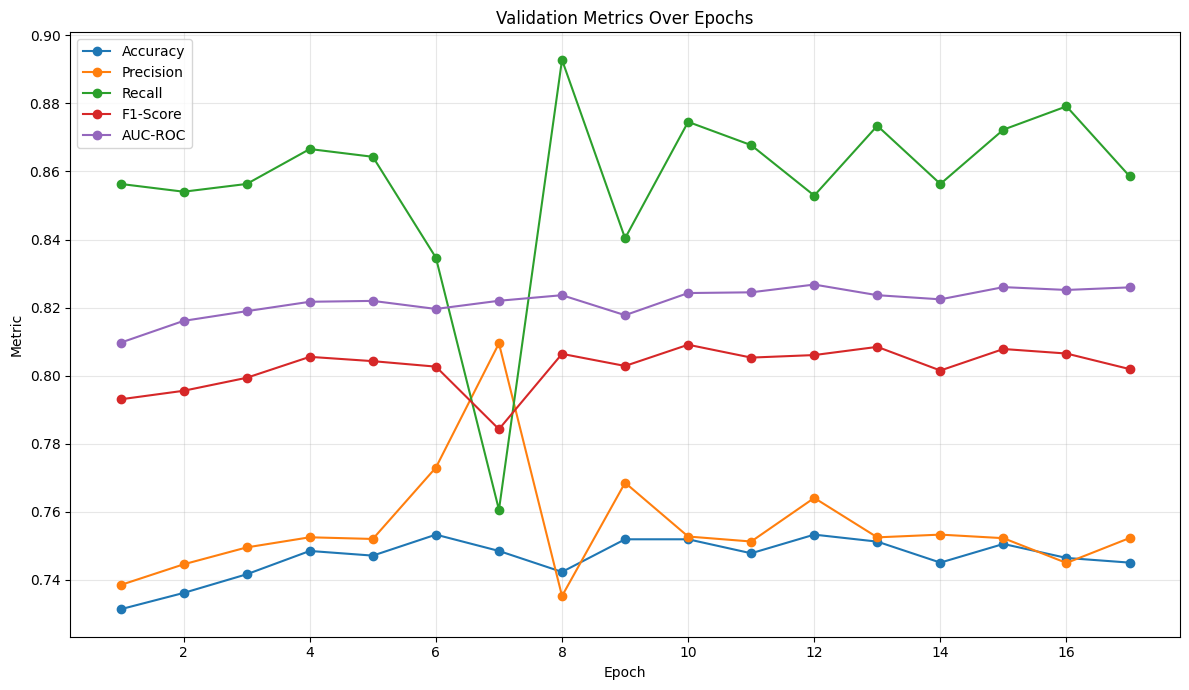

In [31]:
plt.figure(figsize=(12, 7))
plt.plot(metrics_data['epoch'], metrics_data['accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['precision'], label='Precision', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['recall'], label='Recall', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['f1'], label='F1-Score', marker='o')
plt.plot(metrics_data['epoch'], metrics_data['auc'], label='AUC-ROC', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


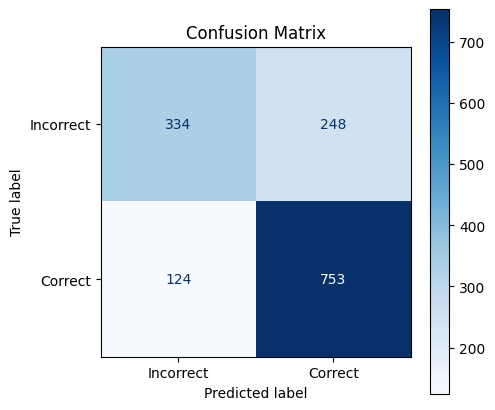

In [32]:
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

cm = np.array(evaluation_results['confusion_matrix'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incorrect", "Correct"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


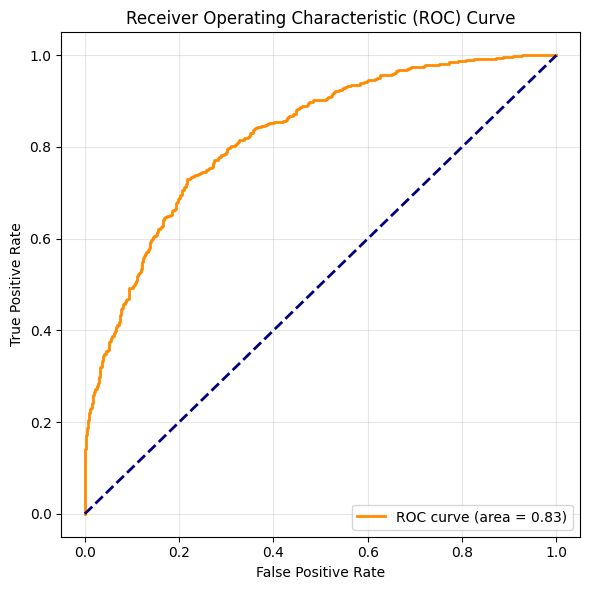

In [33]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(final_targets, final_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
